In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt

from thor_magni_actions.data.config import ACTIONS_INFO_PATH

In [2]:
DATASET = "thor_magni"
SCENARIO_ID = "Scenario_4"
PATH = f"thor-magni-actions/data/interim/{DATASET}/{SCENARIO_ID}"

In [3]:
sorted(os.listdir(PATH))

['THOR-Magni_300922_SC4A_R1.csv',
 'THOR-Magni_300922_SC4A_R2.csv',
 'THOR-Magni_300922_SC4A_R3.csv',
 'THOR-Magni_300922_SC4A_R4.csv',
 'THOR-Magni_300922_SC4B_R1.csv',
 'THOR-Magni_300922_SC4B_R2.csv',
 'THOR-Magni_300922_SC4B_R3.csv',
 'THOR-Magni_300922_SC4B_R4.csv']

In [4]:
FILE = 'THOR-Magni_300922_SC4B_R3.csv' #'THOR-Magni_300922_SC4B_R4.csv'

In [5]:
trajectories_df = pd.read_csv(os.path.join(PATH, FILE))
humans_trajectories_df = trajectories_df[trajectories_df.ag_id.str.startswith("Helmet")]
actions_df = pd.read_csv(os.path.join("thor-magni-actions", ACTIONS_INFO_PATH), index_col=0)

In [6]:
actions_mapping = (
    actions_df.groupby("data_label")["action"]
    .apply(lambda x: list(set(x)))
    .to_dict()
)
actions_mapping

{'Carrier-Box': ['PickBox', 'WalkBox', 'Walk', 'DeliverBox'],
 'Carrier-Bucket': ['DeliverBucket', 'WalkBucket', 'Walk', 'PickBucket'],
 'Carrier-LO': ['Walk', 'WalkLO', 'ObserveCardDraw', 'DrawCard'],
 'Carrier-StorageBinHRI': ['Walk',
  'HRI',
  'WalkStorageBin',
  'DrawCard',
  'PickStorageBin',
  'DeliverStorageBin'],
 'Visitors-Alone': ['Walk', 'DrawCard'],
 'Visitors-AloneHRI': ['Walk', 'HRI', 'DrawCard'],
 'Visitors-Group2': ['DrawCard', 'ObserveCardDraw', 'Walk'],
 'Visitors-Group3': ['Walk', 'ObserveCardDraw', 'DrawCard']}

In [7]:
actions_df["action"].unique()

array(['DrawCard', 'Walk', 'ObserveCardDraw', 'WalkLO', 'PickBucket',
       'WalkBucket', 'DeliverBucket', 'PickBox', 'WalkBox', 'DeliverBox',
       'HRI', 'PickStorageBin', 'WalkStorageBin', 'DeliverStorageBin'],
      dtype=object)

In [8]:
actions_df[(actions_df["action"] == "ObserveCardDraw") & (actions_df["data_label"] == "Visitors-AloneHRI")]["file_name"].unique()

array([], dtype=object)

In [9]:
actions_df_fn = actions_df.groupby("file_name")
file_actions = actions_df_fn.get_group(FILE)

In [10]:
file_actions

,file_name,qtm_frame_act,ag_id,data_label,action
0,THOR-Magni_300922_SC4B_R3.csv,1,Helmet_10,Visitors-Group2,ObserveCardDraw
1,THOR-Magni_300922_SC4B_R3.csv,2,Helmet_10,Visitors-Group2,ObserveCardDraw
2,THOR-Magni_300922_SC4B_R3.csv,3,Helmet_10,Visitors-Group2,ObserveCardDraw
3,THOR-Magni_300922_SC4B_R3.csv,4,Helmet_10,Visitors-Group2,ObserveCardDraw
4,THOR-Magni_300922_SC4B_R3.csv,5,Helmet_10,Visitors-Group2,ObserveCardDraw
...,...,...,...,...,...
23183,THOR-Magni_300922_SC4B_R3.csv,24610,Helmet_8,Visitors-AloneHRI,Walk
23184,THOR-Magni_300922_SC4B_R3.csv,24611,Helmet_8,Visitors-AloneHRI,Walk
23185,THOR-Magni_300922_SC4B_R3.csv,24612,Helmet_8,Visitors-AloneHRI,Walk
23186,THOR-Magni_300922_SC4B_R3.csv,24613,Helmet_8,Visitors-AloneHRI,Walk


In [11]:
actions_helmets = file_actions["ag_id"].unique()
actions_helmets

array(['Helmet_10', 'Helmet_8'], dtype=object)

In [12]:
act_trajs_dfs = []

for helmet_id in actions_helmets:
    helmet_trajs_df = humans_trajectories_df[
        humans_trajectories_df["ag_id"] == helmet_id
    ]
    helmet_act_df = file_actions[file_actions.ag_id == helmet_id]
    merged_df = pd.merge_asof(
        helmet_trajs_df.sort_values("frame_id"),
        helmet_act_df[["file_name", "qtm_frame_act", "action"]].sort_values("qtm_frame_act"),
        left_on="frame_id",
        right_on="qtm_frame_act",
        direction="nearest",
        # tolerance=None,
    )
    act_trajs_dfs.append(merged_df)

In [13]:
actions_trajs_merged = pd.concat(act_trajs_dfs).set_index("Time").sort_index()

In [14]:
def get_groups_continuous_tracking(dynamic_agent_data: pd.DataFrame):
    """get groups of continuous tracking/no-tracking"""
    mask = dynamic_agent_data[["x", "y"]].isna().any(axis=1)
    groups = (mask != mask.shift()).cumsum()
    groups_of_continuous_tracking = dynamic_agent_data.groupby(groups)
    return groups_of_continuous_tracking


def visualize_actions(actions_trajs_merged: pd.DataFrame):
    all_act = list(actions_trajs_merged["action"].unique())
    actions_colors = plt.cm.get_cmap(
        "tab20", len(all_act)
    )
    helmets = actions_trajs_merged["ag_id"].unique()
    fig, axs = plt.subplots(nrows=1, ncols=len(helmets), figsize=(6 * len(helmets), 6))
    for i, helmet in enumerate(helmets):
        ax_handler = axs if len(helmets) == 1 else axs[i]
        helmet_df = actions_trajs_merged[actions_trajs_merged["ag_id"] == helmet]
        role = helmet_df["data_label"].iloc[0]
        ax_handler.set_title(f"{helmet} with {role} role", fontsize=14)
        unique_actions = helmet_df["action"].unique()
        for action in unique_actions:
            if not isinstance(action, str):
                continue
            tracklet_act = helmet_df[helmet_df["action"] == action]
            groups_of_continuous_tracking = get_groups_continuous_tracking(
                tracklet_act
            )
            lbls = 0
            for _, group in groups_of_continuous_tracking:
                if group[["x", "y", "z"]].isna().any(axis=0).all():
                    continue
                else:
                    lbls+=1
                act = group["action"].iloc[0]
                ax_handler.scatter(
                    group["x"],
                    group["y"],
                    label=act if lbls == 1 else "",
                    color=actions_colors(all_act.index(act)),
                )
        ax_handler.legend(fontsize=14)
        ax_handler.set_xlim([-9,10]);
        ax_handler.set_ylim([-4.5,4.5]);
    fig.tight_layout()

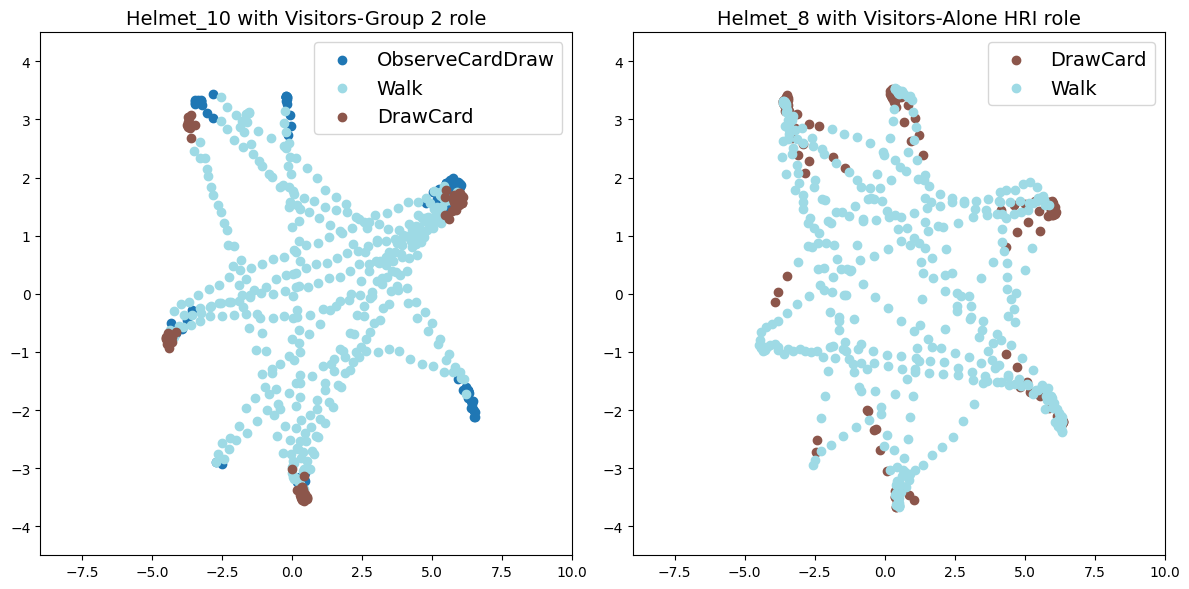

In [15]:
visualize_actions(actions_trajs_merged)